In [1]:
from lzt_utils.dataset import LztDataset
from lzt_utils.constants import N_RINGS
from lzt_utils.root import rdf_column_names, rdf_to_pandas, open_vector
from lzt_utils import formulas
from lzt_utils.utils import set_logger
from lzt_utils.norms import norm1
import lzt_utils.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import os
from pathlib import Path
import ROOT
import numpy as np
import pandas as pd
import logging
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ROOT)
set_logger()

Module libc not found.


In [2]:
lzt_data = Path.home() / 'ext_data' / 'lorenzetti' / 'V2.1.0'
output_dir = lzt_data / 'profiles' / 'boosted-lorenzetti-2025-04-10-12-00-00'
output_dir.mkdir(exist_ok=True, parents=True)
datasets_info = {
    'user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_Zee': {
        'color': 'blue',
        'alias': 'zee'
    },
    'user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_JF17': {
        'color': 'red',
        'alias': 'jf17'
    }
}
datasets = {}
for dir_name, info in datasets_info.items():
    ds = LztDataset.from_dir(lzt_data/dir_name)
    ds.color = info['color']
    datasets[info['alias']] = ds
datasets

{'zee': LztDataset(path=/root/ext_data/lorenzetti/V2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_Zee, label=Z->ee),
 'jf17': LztDataset(path=/root/ext_data/lorenzetti/V2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_JF17, label=Jets et > 17GeV)}

In [3]:
def ntuple_aggregation(df: pd.DataFrame) -> pd.Series:
    n_objects = len(df)
    if n_objects:
        ordered_idxs = df.index[df['cl_e'].argsort()][::-1]
        highest_e1 = df.loc[ordered_idxs[0], 'cl_e']
        highest_e2 = df.loc[ordered_idxs[1], 'cl_e'] if n_objects > 1 else np.nan
        eta1 = df.loc[ordered_idxs[0], 'el_eta']
        eta2 = df.loc[ordered_idxs[1], 'el_eta'] if n_objects > 1 else np.nan
        phi1 = df.loc[ordered_idxs[0], 'el_phi']
        phi2 = df.loc[ordered_idxs[1], 'el_phi'] if n_objects > 1 else np.nan
    else:
        highest_e1 = np.nan
        highest_e2 = np.nan
        eta1 = np.nan
        eta2 = np.nan
        phi1 = np.nan
        phi2 = np.nan
    return pd.Series({
        'n_objects': n_objects,
        # Plus 1 to account for the event itself
        'n_duplicates': df.duplicated().sum()+1,
        'highest_e1': highest_e1,
        'highest_e2': highest_e2,
        'eta1': eta1,
        'eta2': eta2,
        'phi1': phi1,
        'phi2': phi2
    })

In [4]:
for dataset_name, dataset in datasets.items():
    ntuple_rdf = dataset.get_ntuple_rdf()
    rings_cols, ntuple_rdf = open_vector('cl_rings', N_RINGS, ntuple_rdf)
    column_names = rdf_column_names(ntuple_rdf)
    ntuple_pdf = rdf_to_pandas(ntuple_rdf, [name for name in column_names if name != 'rings'], nrows=-1)
    for name, dtype in ntuple_pdf.dtypes.items():
        if name.startswith('rings_'): continue
    dataset.ntuple_pdf = ntuple_pdf
datasets

{'zee': LztDataset(path=/root/ext_data/lorenzetti/V2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_Zee, label=Z->ee),
 'jf17': LztDataset(path=/root/ext_data/lorenzetti/V2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_JF17, label=Jets et > 17GeV)}

In [5]:
for dataset in datasets.values():
    filepath = output_dir / f'{dataset.name}_ntuple_grouped_clusters.parquet'
    if os.path.exists(filepath):
        ntuple_grouped_clusters = pd.read_parquet(filepath)
    else:
        ntuple_grouped_clusters = dataset.ntuple_pdf.groupby('EventNumber').apply(ntuple_aggregation)
        ntuple_grouped_clusters['deltaR'] = formulas.deltaR(ntuple_grouped_clusters['eta1'].values,
                                                            ntuple_grouped_clusters['phi1'].values,
                                                            ntuple_grouped_clusters['eta2'].values,
                                                            ntuple_grouped_clusters['phi2'].values)
        logging.info(f"DataFrame shape: {ntuple_grouped_clusters.shape}")
        ntuple_grouped_clusters.to_parquet(filepath)
    dataset.ntuple_grouped_clusters = ntuple_grouped_clusters

# Clean Data

In [26]:
dataset_alias = 'jf17'
ring_threshold = 1e4
n_rows = len(datasets[dataset_alias].ntuple_pdf)
logging.info(f'Uncleaned data has {n_rows}')
selector = (datasets[dataset_alias].ntuple_pdf[rings_cols] <= ring_threshold).all(axis=1) & (datasets[dataset_alias].ntuple_pdf[rings_cols] >= -ring_threshold).all(axis=1)
datasets[dataset_alias].ntuple_pdf.loc[selector]

2025-04-10 19:38:51 | INFO | root | 587930774 | 4 | Uncleaned data has 21998


,EventNumber,RunNumber,avgmu,cl_deta,cl_dphi,cl_e,cl_e0,cl_e1,cl_e2,cl_e233,...,el_phi,el_tight,el_vloose,mc_e,mc_et,mc_eta,mc_pdgid,mc_phi,seed_eta,seed_phi
0,9233,250401,0.0,0.2,0.2,40580.496094,-781.682922,13322.479492,26261.693359,12268.679688,...,0.0123,False,False,"[3.9059667587280273, 0.2257702797651291, 1.525...","[3.3336808681488037, 0.17074386775493622, 1.27...","[-0.562251627445221, -0.7827051281929016, -0.6...","[-321.0, 22.0, 22.0, 22.0, 211.0, 22.0, 211.0,...","[-0.11432540416717529, 0.004769668914377689, 0...",-0.664123,0.020916
1,9233,250401,0.0,0.2,0.2,15928.989258,-945.121216,5604.595703,10851.478516,3356.591309,...,2.0740,False,False,"[3.9059667587280273, 0.2257702797651291, 1.525...","[3.3336808681488037, 0.17074386775493622, 1.27...","[-0.562251627445221, -0.7827051281929016, -0.6...","[-321.0, 22.0, 22.0, 22.0, 211.0, 22.0, 211.0,...","[-0.11432540416717529, 0.004769668914377689, 0...",-0.228589,2.130013
2,9237,250401,0.0,0.2,0.2,82045.492188,-102.976448,50595.449219,31085.962891,19354.359375,...,-1.4358,False,True,"[3.0379531383514404, 14.518266677856445, 3.952...","[0.8953250050544739, 4.683751583099365, 1.4105...","[1.8163611888885498, 1.7973084449768066, 1.690...","[-3122.0, 211.0, 22.0, 22.0, -321.0, 22.0]","[-1.5560593605041504, -1.57377290725708, -1.40...",1.721466,-1.443848
3,9237,250401,0.0,0.2,0.2,30614.828125,-14.314024,6984.799805,21860.187500,6026.640137,...,1.3622,False,False,"[3.0379531383514404, 14.518266677856445, 3.952...","[0.8953250050544739, 4.683751583099365, 1.4105...","[1.8163611888885498, 1.7973084449768066, 1.690...","[-3122.0, 211.0, 22.0, 22.0, -321.0, 22.0, 211...","[-1.5560593605041504, -1.57377290725708, -1.40...",0.562247,1.369394
4,9244,250401,0.0,0.2,0.2,136580.609375,0.000000,42048.515625,91363.679688,26276.355469,...,2.7366,False,False,"[6.259101867675781, 4.082688808441162, 6.68451...","[1.2779561281204224, 0.8292437791824341, 1.656...","[2.2710790634155273, 2.2760701179504395, 2.072...","[211.0, -211.0, -211.0, 211.0, -211.0, 22.0, -...","[2.8647513389587402, 2.8429341316223145, 2.910...",2.105717,2.727956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21990,4986,250401,0.0,0.2,0.2,23853.867188,222.377182,8040.914062,15250.659180,2947.654297,...,0.2823,False,False,"[1.6115814447402954, 8.674488067626953, 5.4607...","[0.9646117091178894, 4.424677848815918, 2.8577...","[-1.101635217666626, -1.2936832904815674, -1.2...","[22.0, 211.0, 22.0, -2212.0, -211.0, 22.0, 211...","[2.696467161178589, 2.695383310317993, 2.68826...",-0.738298,0.321863
21991,4986,250401,0.0,0.2,0.2,10500.476562,31.288923,6012.036621,3891.045410,1864.180786,...,-1.1167,False,False,"[1.6115814447402954, 8.674488067626953, 5.4607...","[0.9646117091178894, 4.424677848815918, 2.8577...","[-1.101635217666626, -1.2936832904815674, -1.2...","[22.0, 211.0, 22.0, -2212.0, -211.0, 22.0, 211...","[2.696467161178589, 2.695383310317993, 2.68826...",-1.972986,-1.197453
21992,4998,250401,0.0,0.2,0.2,34833.437500,-607.927124,14633.407227,18938.421875,5830.246582,...,-2.0248,False,False,"[1.7659026384353638, 4.577688217163086, 0.8585...","[1.4894472360610962, 3.946139335632324, 0.7517...","[0.6002264618873596, 0.5584740042686462, 0.526...","[22.0, 22.0, 22.0, -211.0, 22.0, 22.0, 22.0, 2...","[-2.089733362197876, -2.0395779609680176, -1.9...",0.660849,-1.892927
21993,4998,250401,0.0,0.2,0.2,15802.188477,-467.830963,4681.107422,9449.252930,1931.383911,...,0.6995,False,False,"[1.7659026384353638, 4.577688217163086, 0.8585...","[1.4894472360610962, 3.946139335632324, 0.7517...","[0.6002264618873596, 0.5584740042686462, 0.526...","[22.0, 22.0, 22.0, -211.0, 22.0, 22.0, 22.0, 2...","[-2.089733362197876, -2.0395779609680176, -1.9...",0.516217,0.692309


# All Rings

/tmp/ipykernel_85556/1627970726.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(output_dir/f'all_rings_{dataset_alias}_{all_rings_normalization_str}.png', bbox_inches='tight', dpi=300)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


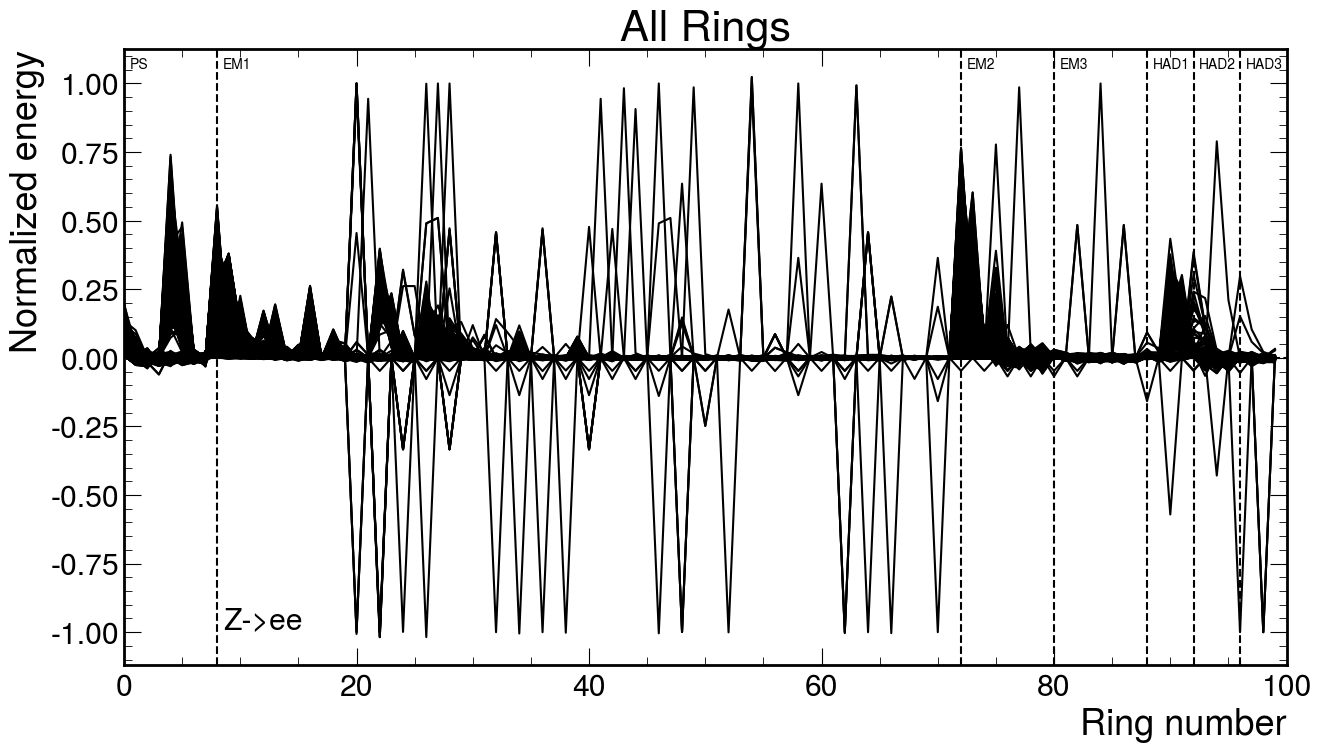

In [13]:
normalize=True
dataset_alias = 'zee'
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(N_RINGS)
lplt.plot_all_rings(datasets[dataset_alias].ntuple_pdf[rings_cols], ax, normalize=normalize, plot_kwargs=dict(color='k'))
ax.plot([], [], ' ', label=datasets[dataset_alias].label)
ax.legend()
# ylim = np.array([-1e4, 1e4])
# ax.set_ylim(*ylim)
ax.set_xlabel('Ring number')
all_rings_normalization_str = 'normalized' if normalize else 'not_normalized'
fig.savefig(output_dir/f'all_rings_{dataset_alias}_{all_rings_normalization_str}.png', bbox_inches='tight', dpi=300)

# Rings Profile

In [ ]:
normalize = False
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    _, ds.mean_rings, ds.std_rings = lplt.plot_rings_profile(ds.ntuple_pdf[rings_cols], ax, normalize=normalize,
                            label=ds.label, add_rings_labels=i==0,
                            color=ds.color)
normalization_str = 'normalized' if normalize else 'not_normalized'
fig.savefig(
    output_dir/f'rings_profile_{normalization_str}.png', bbox_inches='tight', dpi=300)

# $\Delta R$

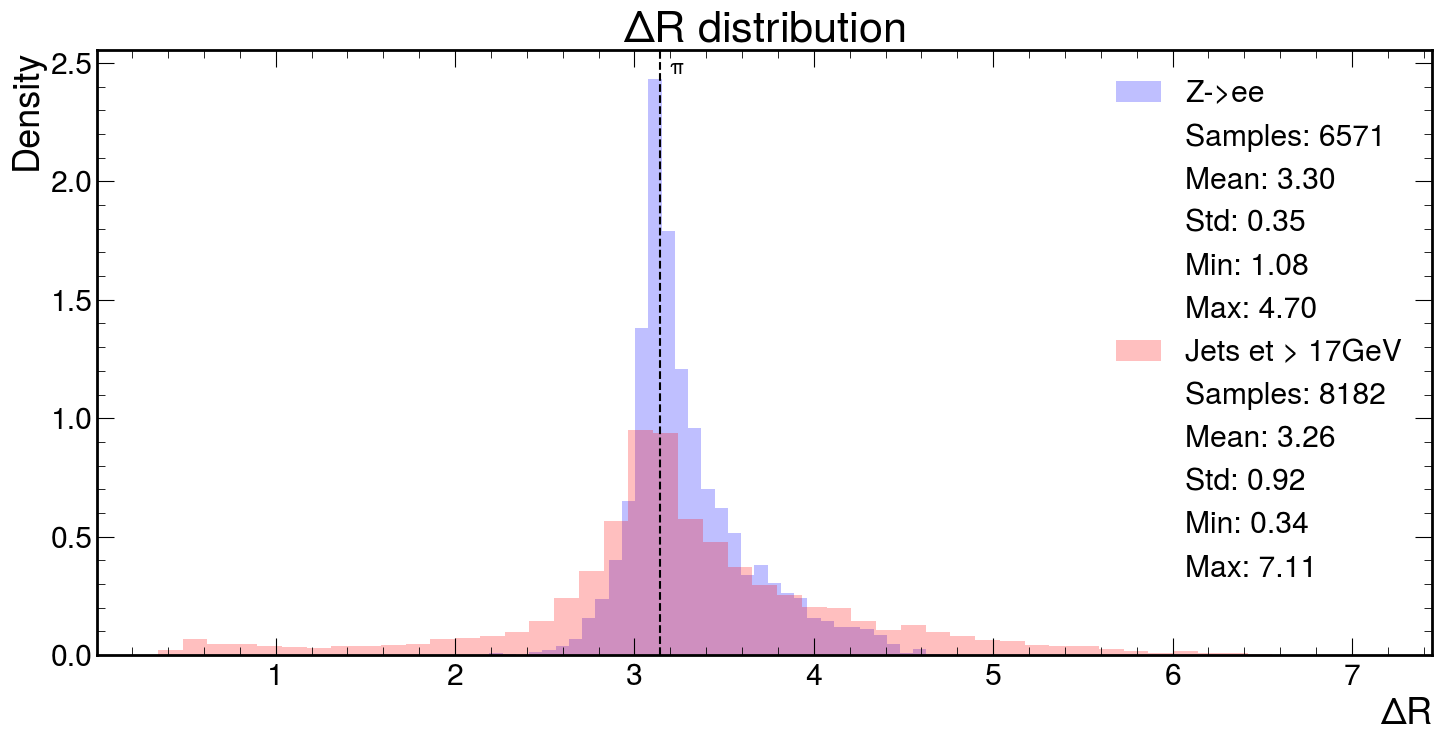

In [52]:
fig, ax = plt.subplots(figsize=(15, 8))
for dataset_name, dataset in datasets.items():
    lplt.histplot(
        dataset.ntuple_grouped_clusters['deltaR'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$\Delta R$',
            ylabel='Density',
            title=r'$\Delta R$ distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset.label,
            color=dataset.color,
            density=True,
            alpha=0.25
        )
    )
_, y_up = ax.get_ylim()
ax.axvline(np.pi, color='k', linestyle='--')
ax.text(np.pi+0.05, y_up*0.97, r'$\pi$',
        verticalalignment='center', fontsize=15)
# ax.axvline(2*np.pi, color='k', linestyle='--')
# ax.text(2*np.pi+0.05, y_up*0.97, r'$2\pi$',
#         verticalalignment='center', fontsize=15)
ax.legend()
fig.tight_layout()
fig.savefig(output_dir / 'deltaR_distribution.png', bbox_inches='tight', dpi=300)

# Object distribution

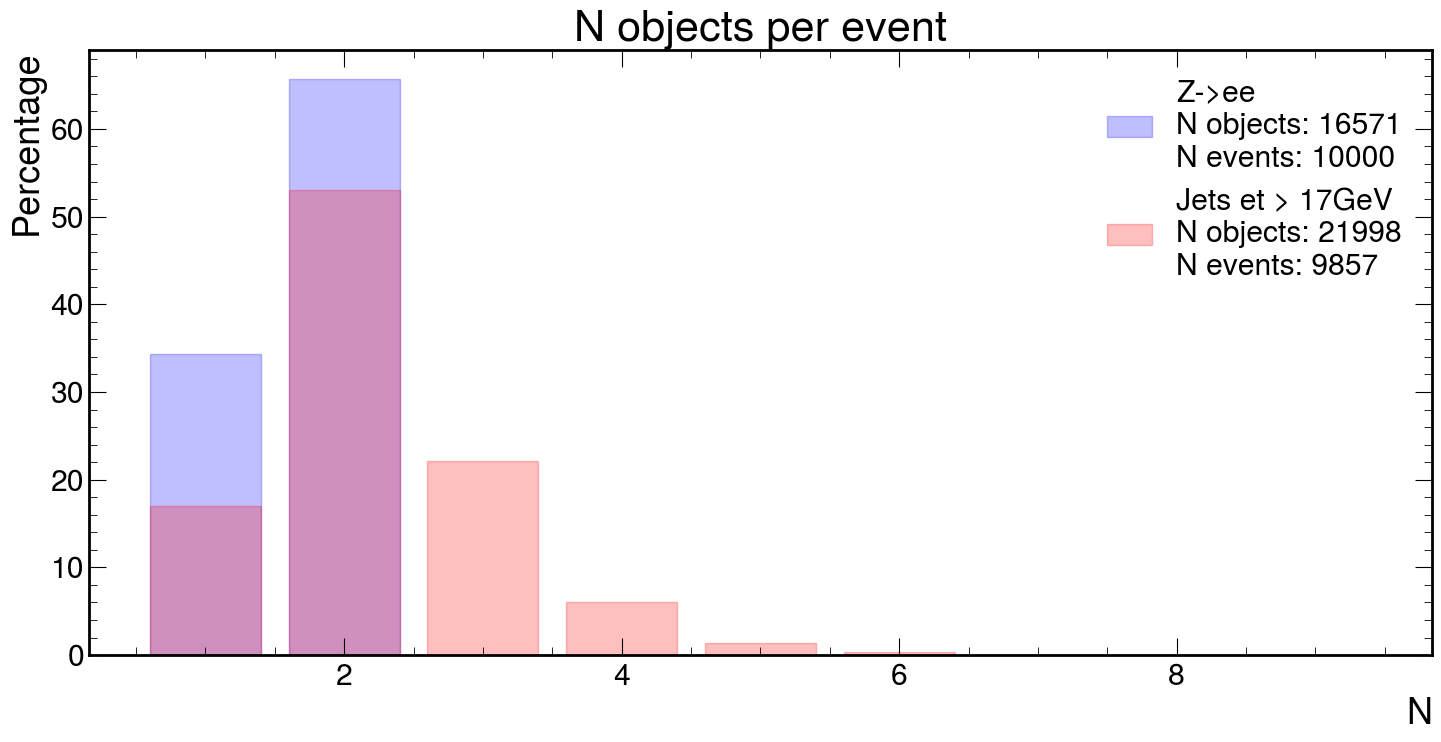

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
for dataset_alias, dataset in datasets.items():
    data_to_plot = dataset.ntuple_grouped_clusters['n_objects'].dropna()
    lplt.categorical_histplot(
        data_to_plot,
        ax=ax,
        metrics=False,
        percentage=True,
        ax_set=dict(
            xlabel='N',
            ylabel='Percentage',
            title='N objects per event',
        ),
        bar_kwargs=dict(
            label=f'{dataset.label}\nN objects: {int(sum(data_to_plot))}\nN events: {len(dataset.ntuple_grouped_clusters)}',
            color=dataset.color,
            edgecolor=dataset.color,
            fill=True,
            alpha=0.25
        )
    )
    # ax.plot([], [], ' ', label=f"N events: {len(dataset.ntuple_grouped_clusters)}")
ax.legend()
fig.tight_layout()
fig.savefig(output_dir/'objects_per_event_distribution.png', bbox_inches='tight', dpi=300)

# Cluster Energy

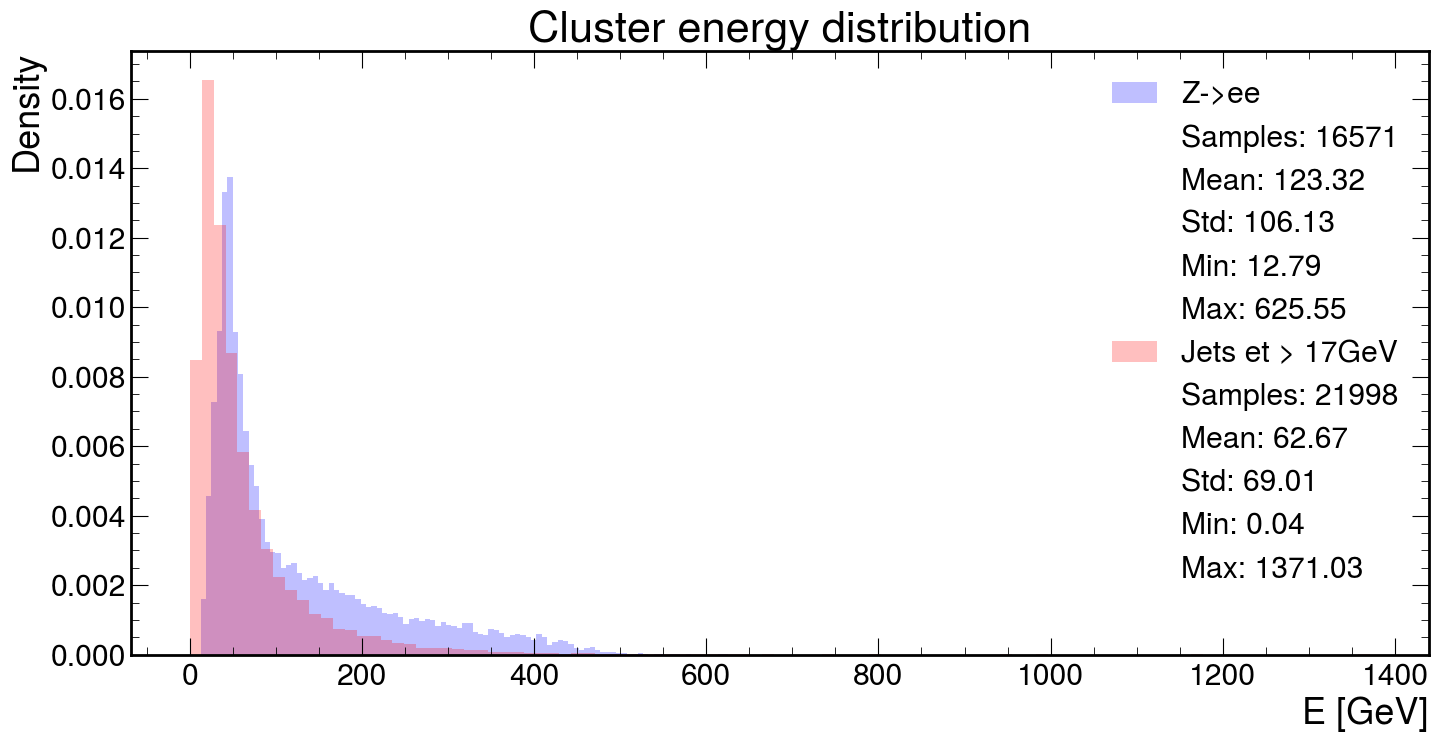

In [59]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cl_e'].dropna()/1000,
        nbins=100,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel='E [GeV]',
            ylabel='Density',
            title='Cluster energy distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'cl_e_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $E_T$

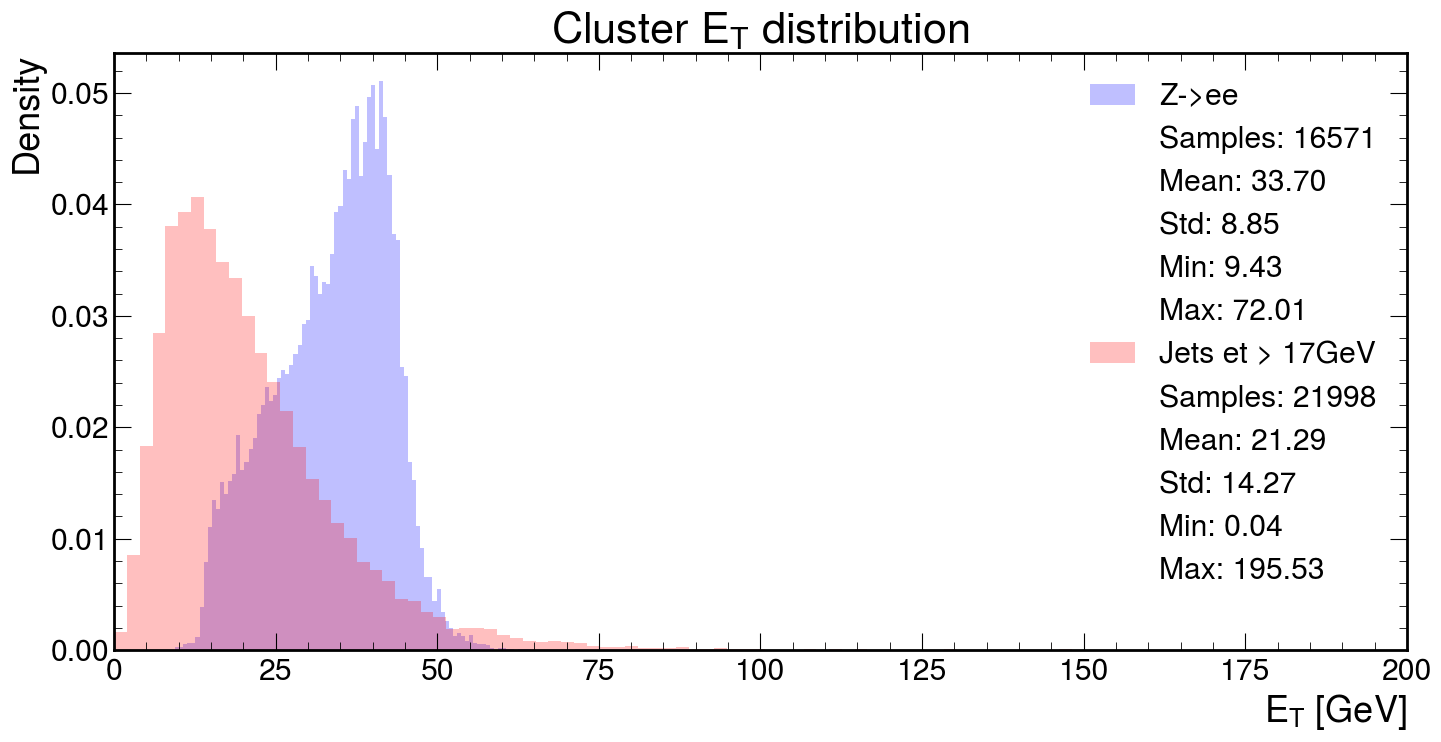

In [58]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cl_et'].dropna()/1000,
        nbins=100,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$E_T$ [GeV]',
            ylabel='Density',
            title=r'Cluster $E_T$ distribution',
            xlim=(0,200)
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
fig.tight_layout()
fig.savefig(output_dir/'cl_et_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $\eta$

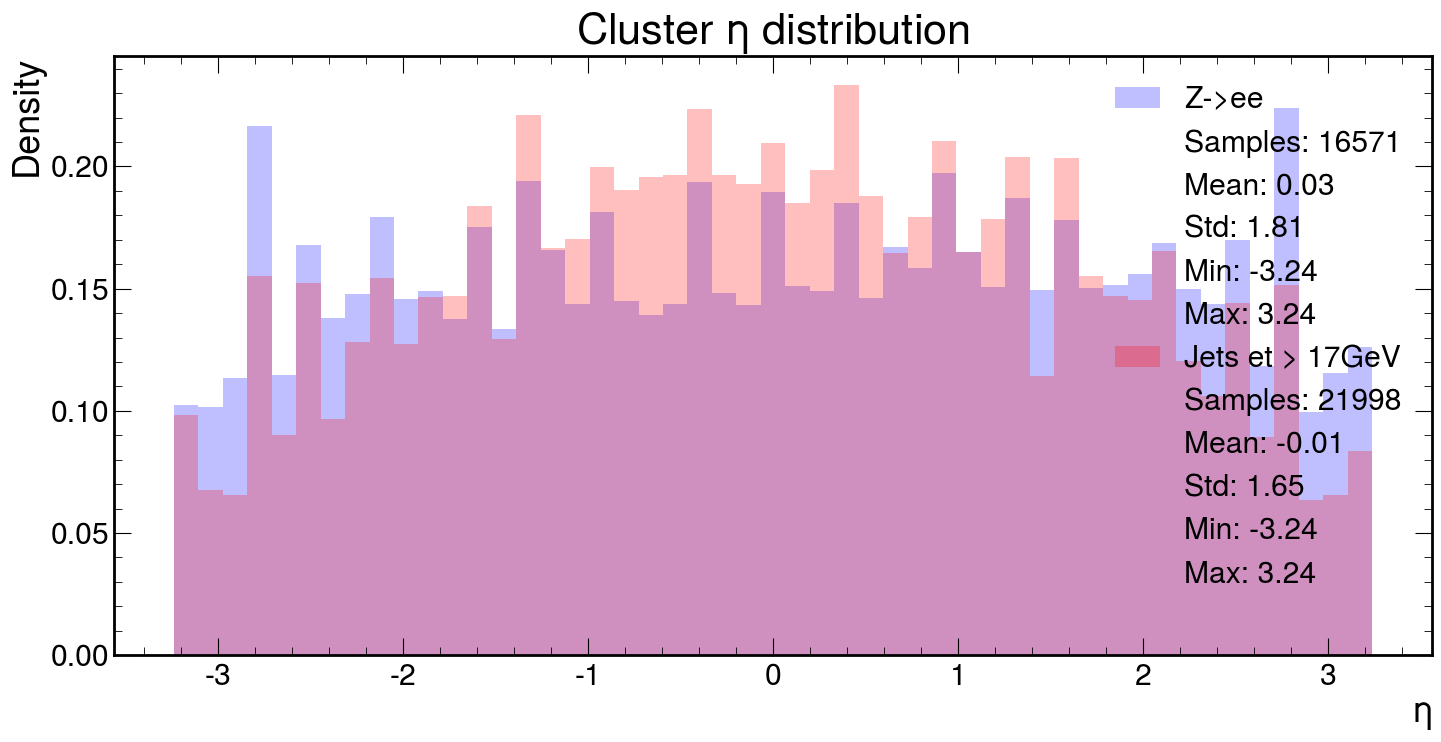

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cl_eta'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$\eta$',
            ylabel='Density',
            title=r'Cluster $\eta$ distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'cl_eta_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $\phi$

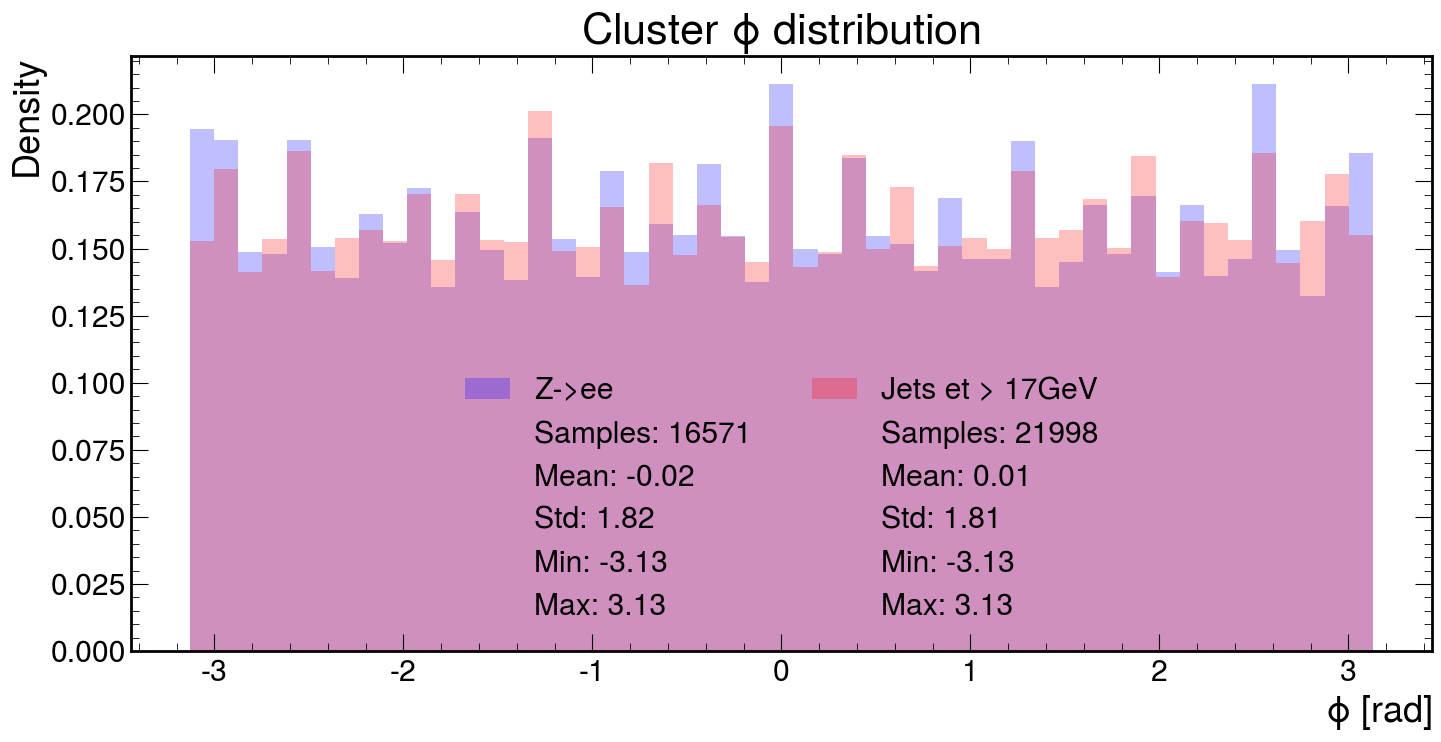

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cl_phi'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$\phi$ [rad]',
            ylabel='Density',
            title=r'Cluster $\phi$ distribution',
        ),
        legend_kwargs=dict(
            loc='lower center',
            ncols=2
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'cl_phi_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $E_{ratio}$

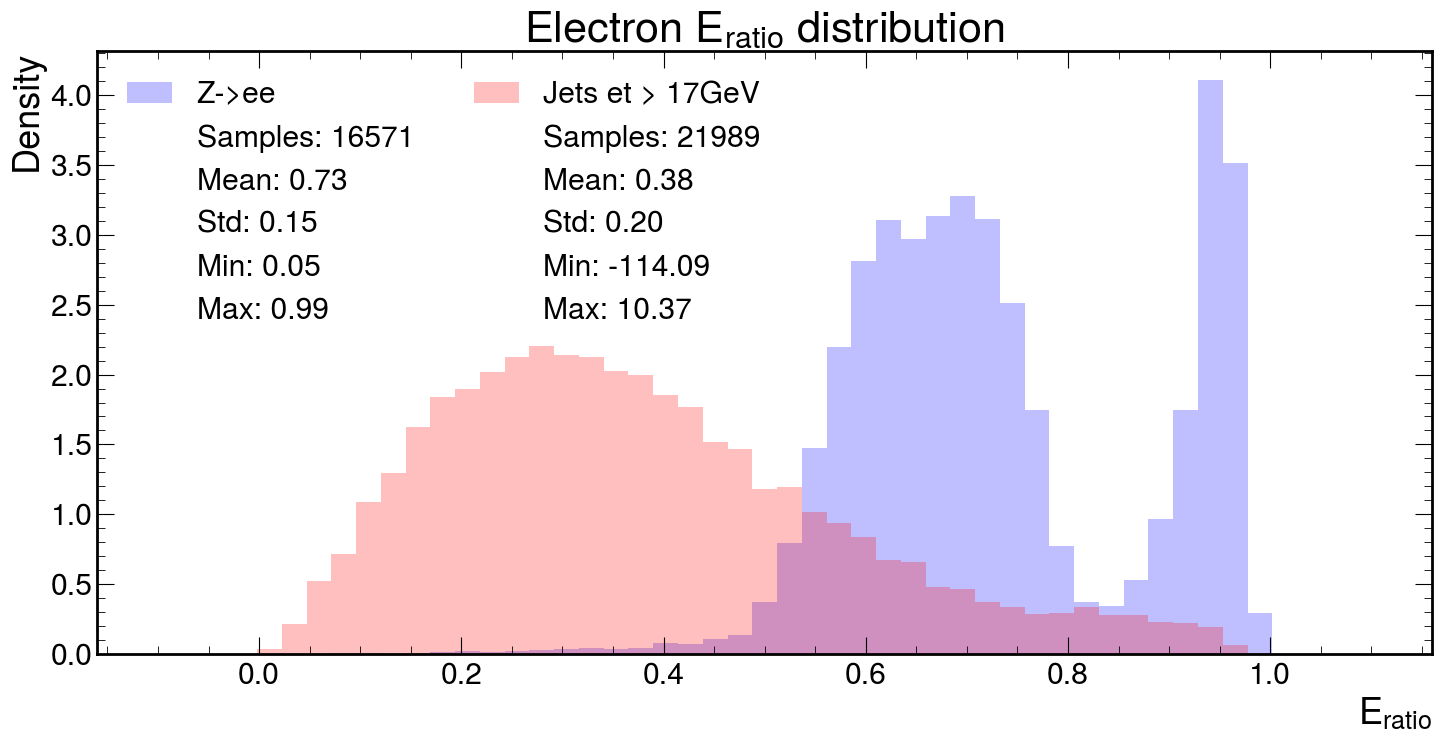

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cl_eratio'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$E_{ratio}$',
            ylabel='Density',
            title=r'Electron $E_{ratio}$ distribution',
        ),
        legend_kwargs=dict(
            ncols=2
        ),
        bin_min=-0.1,
        bin_max=1.1,
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'cl_eratio_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $R_{had}$

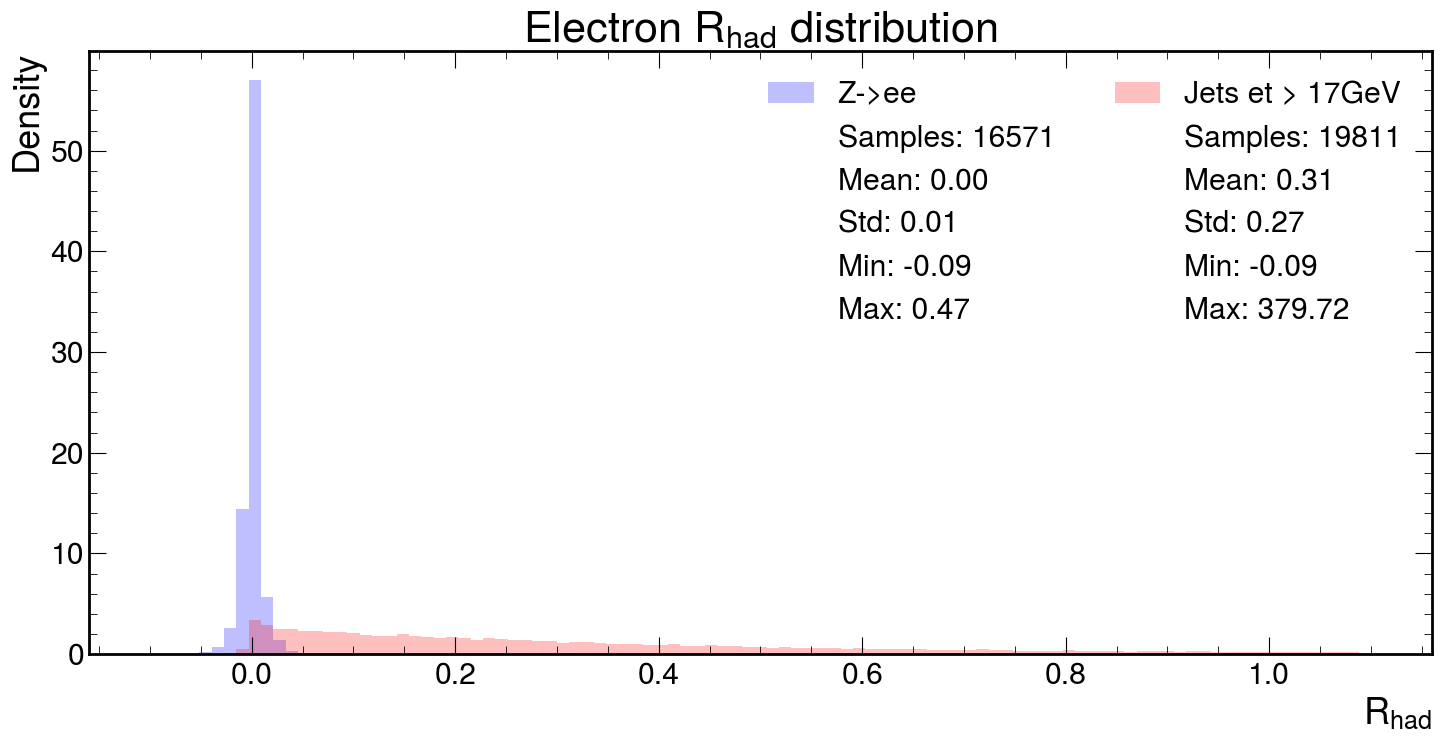

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cl_rhad'].dropna(),
        nbins=100,
        ax=ax,
        metrics=True,
        bin_max=1.1,
        bin_min=-0.1,
        ax_set=dict(
            xlabel=r'$R_{had}$',
            ylabel='Density',
            title=r'Electron $R_{had}$ distribution',
        ),
        legend_kwargs=dict(
            ncols=2
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'cl_rhad_distribution.png', bbox_inches='tight', dpi=300)

# Eletron $E_T$

2025-04-11 07:09:57 | INFO | root | 802765698 | 3 | Plotting zee...


2025-04-11 07:09:57 | INFO | root | 802765698 | 3 | Plotting jf17...
2025-04-11 07:09:57 | INFO | root | 802765698 | 25 | Finished plotting


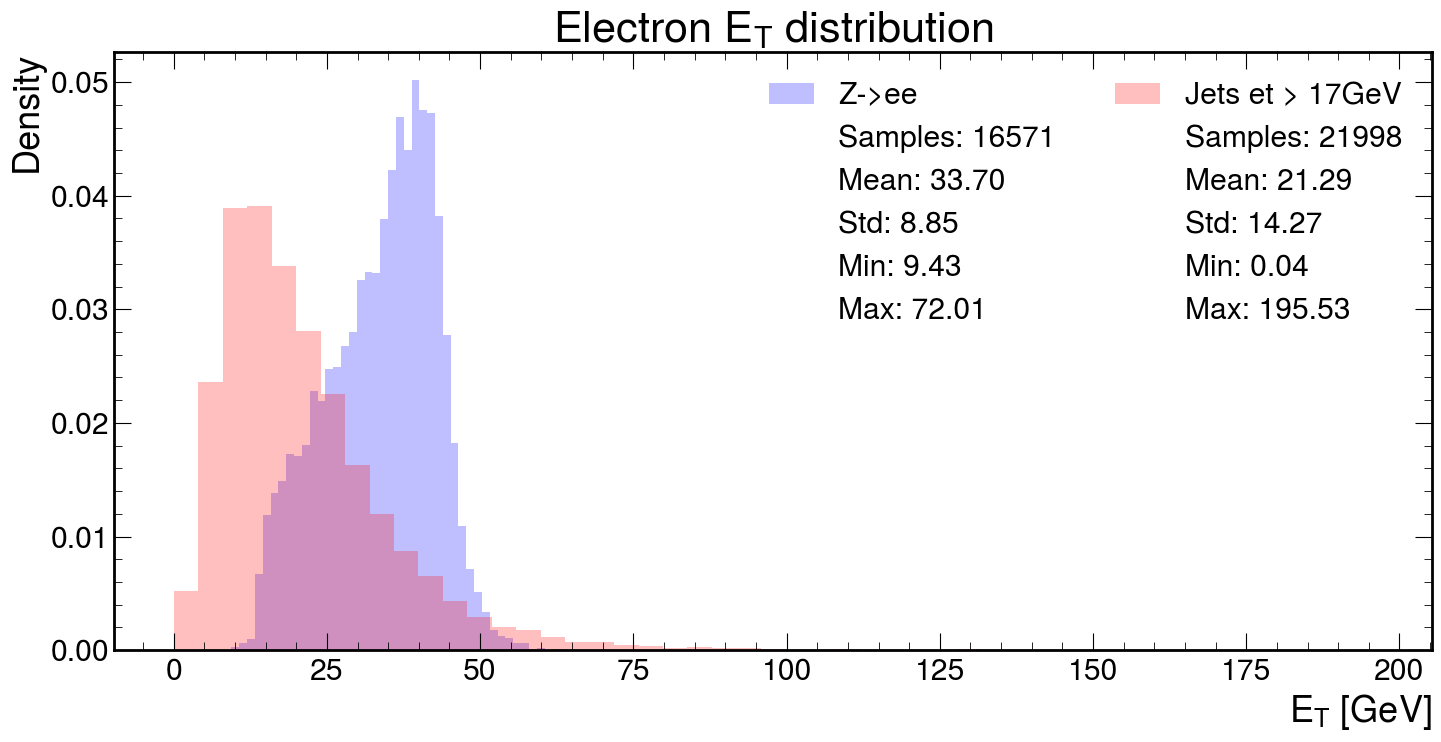

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    logging.info(f'Plotting {ds_name}...')
    lplt.histplot(
        ds.ntuple_pdf['el_et'].dropna()/1000,
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$E_T$ [GeV]',
            ylabel='Density',
            title=r'Electron $E_T$ distribution',
        ),
        legend_kwargs=dict(
            ncols=2
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
logging.info('Finished plotting')
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'el_et_distribution.png', bbox_inches='tight', dpi=300)

# Eletron $\eta$

2025-04-11 07:10:30 | INFO | root | 1706863623 | 3 | Plotting zee...
2025-04-11 07:10:30 | INFO | root | 1706863623 | 3 | Plotting jf17...
2025-04-11 07:10:31 | INFO | root | 1706863623 | 22 | Finished plotting


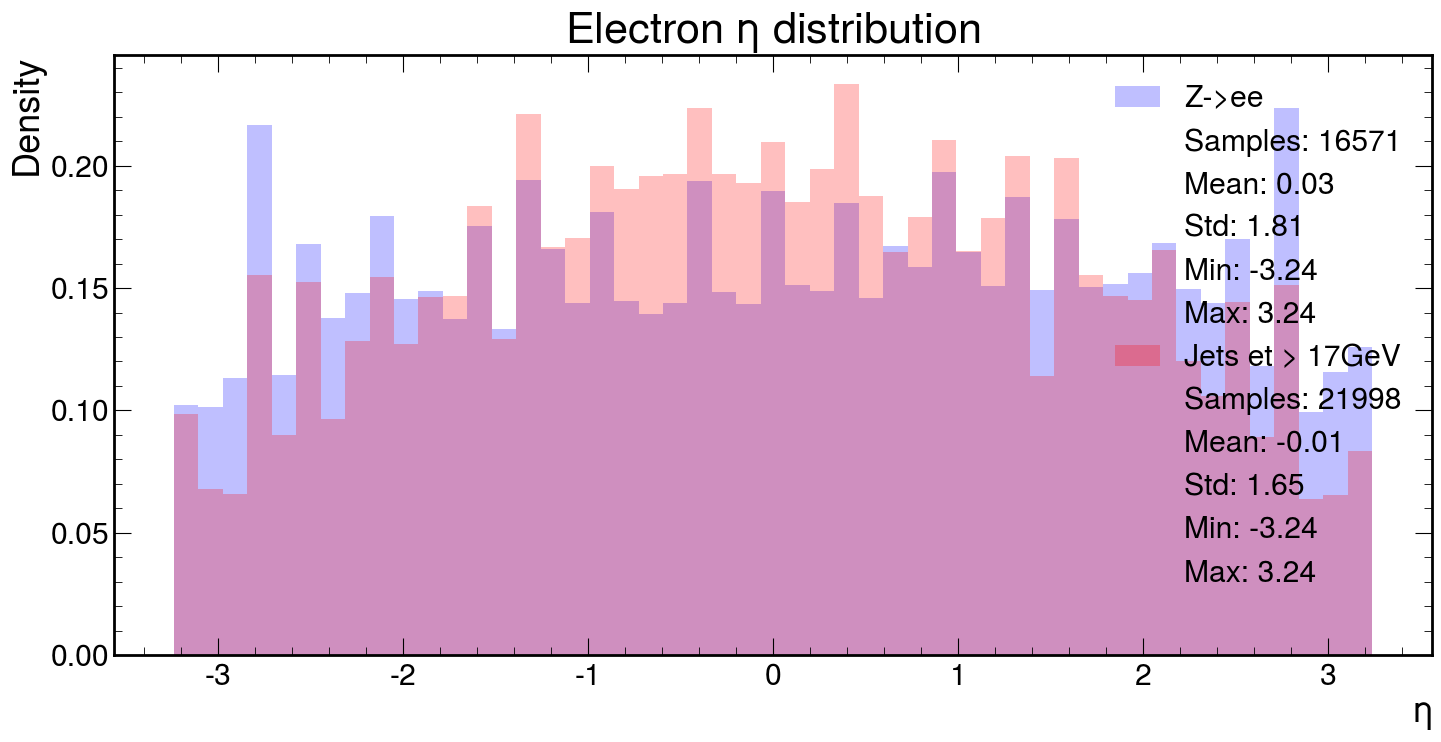

In [30]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    logging.info(f'Plotting {ds_name}...')
    lplt.histplot(
        ds.ntuple_pdf['el_eta'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$\eta$',
            ylabel='Density',
            title=r'Electron $\eta$ distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
logging.info('Finished plotting')
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'electron_eta_distribution.png', bbox_inches='tight', dpi=300)

# Eletron $\phi$

2025-04-11 07:10:53 | INFO | root | 1910388419 | 3 | Plotting zee...
2025-04-11 07:10:53 | INFO | root | 1910388419 | 3 | Plotting jf17...
2025-04-11 07:10:53 | INFO | root | 1910388419 | 22 | Finished plotting


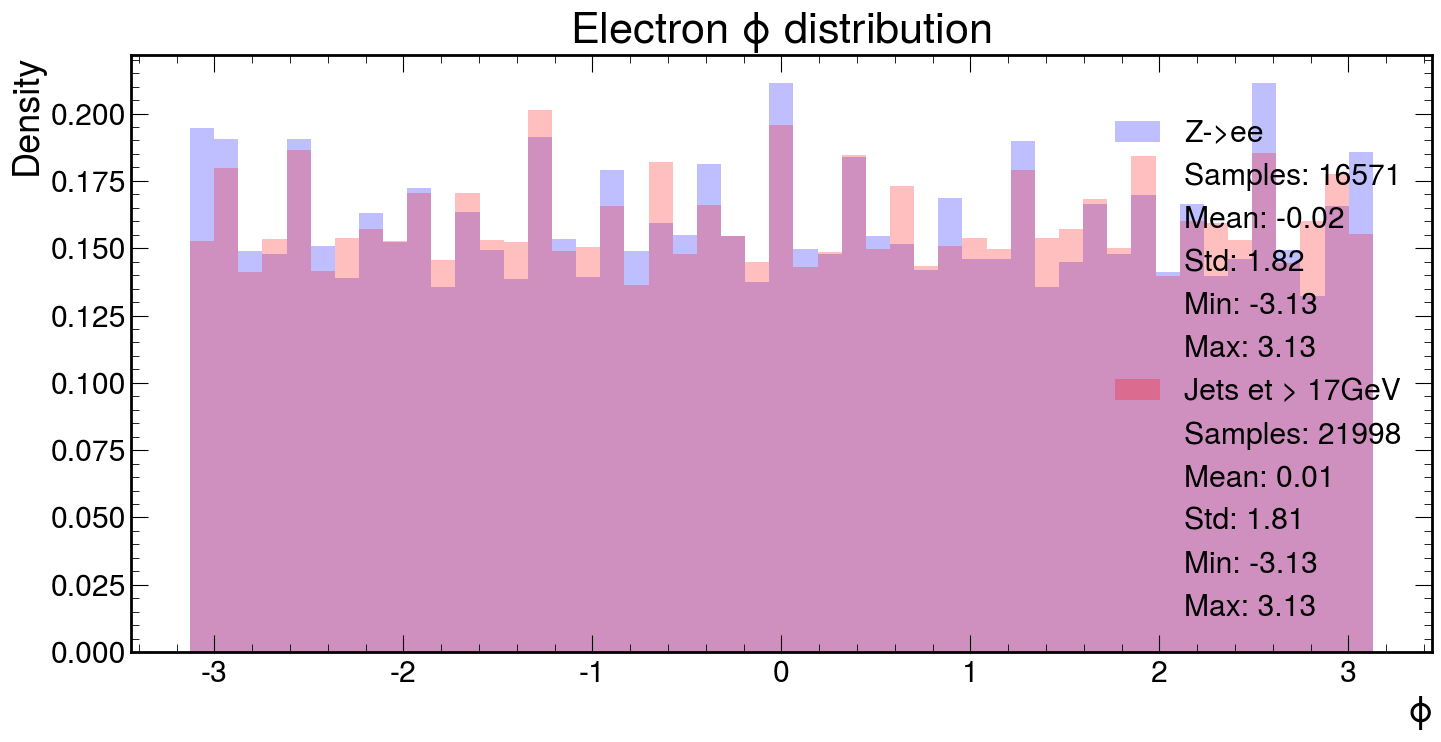

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    logging.info(f'Plotting {ds_name}...')
    lplt.histplot(
        ds.ntuple_pdf['el_phi'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$\phi$',
            ylabel='Density',
            title=r'Electron $\phi$ distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
logging.info('Finished plotting')
# ax.xaxis.set_label_coords(0.1, -0.1)
fig.tight_layout()
fig.savefig(output_dir/'electron_phi_distribution.png', bbox_inches='tight', dpi=300)

In [ ]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(
#     datasets['zee'].ntuple_pdf,
#     title="Zee Ntuple PDF",
#     explorative=True,
#     pool_size=8
# )
# profile.to_file(output_dir / "zee_ntuple_pdf_report.html")